In [458]:
using RobustAndOptimalControl
using ControlSystemsBase 
using Plots

In [459]:
function parse_tf_from_file(fname)

    file = open(fname, "r")
    lines = readlines(file)
    close(file)

    # join to one String
    lines = join(lines)
    num = split(lines, "]")[1]
    num = replace(num, "[" => "")

    den = split(lines, "]")[2]
    den = replace(den, "[" => "")
    den = replace(den, "]" => "")


    num_f = []
    for fs in split(num, " ")
        if fs == ""
            continue
        end
        push!(num_f, parse(Float64, fs))
    end

    den_f = []
    for fs in split(den, " ")
        if fs == ""
            continue
        end
        push!(den_f, parse(Float64, fs))
    end

    num_f = Vector{Float64}(num_f)
    den_f = Vector{Float64}(den_f)


    G = tf(num_f, den_f)
    G = minreal(G)
    return G
end

parse_tf_from_file (generic function with 1 method)

# Plant

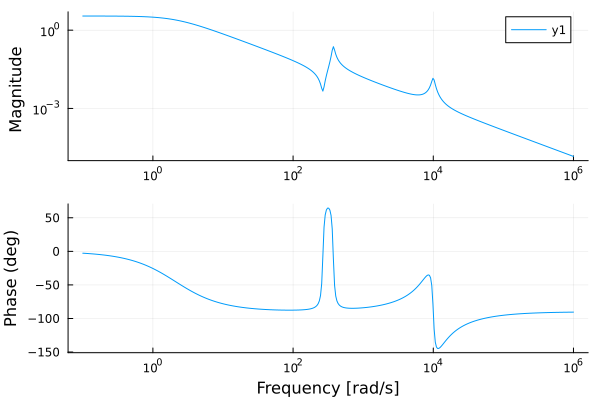

In [460]:
s = tf("s")
G = parse_tf_from_file("tf_txt/Gf.txt")

bodeplot(G)

In [461]:
function pt2(w0,d)
    s = tf("s")
    return w0^2/(s^2 + 2*d*w0*s + w0^2)
end

pt2 (generic function with 1 method)

# Uncertainty

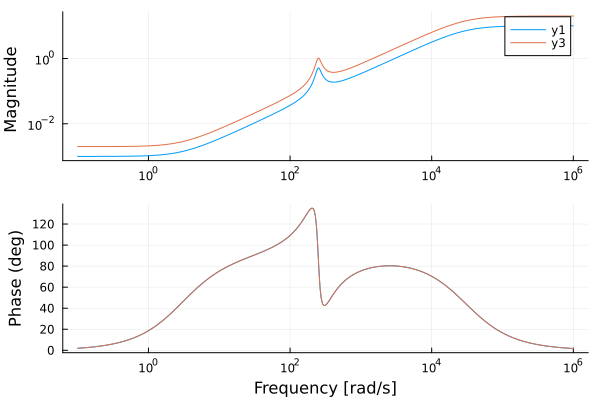

In [462]:

W_delta0 = parse_tf_from_file("tf_txt/W_delta.txt")
W_delta = W_delta0*2
bodeplot([W_delta0,W_delta])


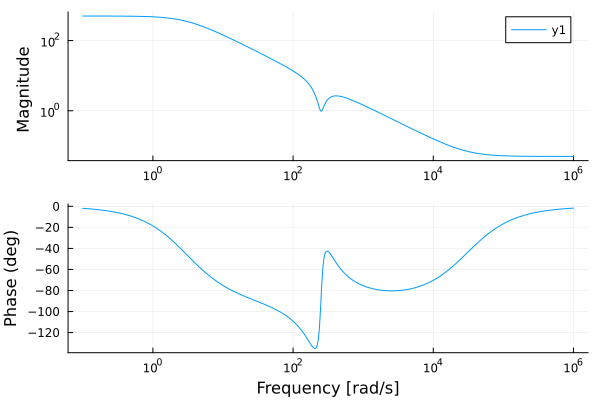

In [463]:
bodeplot(1/W_delta)

# Control limit

25132.741228718343

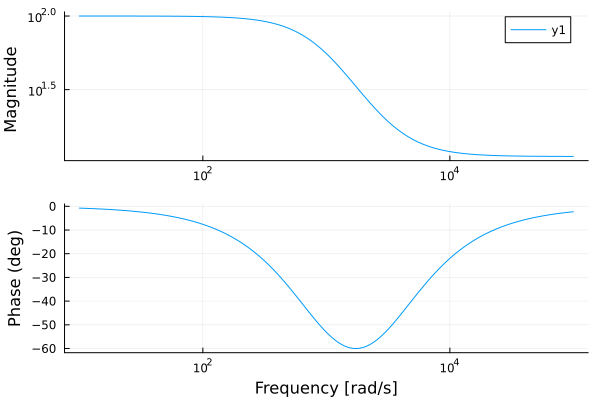

In [464]:


# Max Torque, and Nyquist freq as dynamic limit
#w_nyq = pi/(125*1e-6)
w_lim = 1e3
print(w_nyq)
max_T = 80

#WU = pt2(w_nyq,1)/pt2(w_nyq*5,1) * 30
#WU = pt2(200,1)/pt2(500,1) * 500 # best so far
#WU = pt2(150,1)/pt2(300,1) * 300 

WU = pt2(w_lim,1)*100 * 1/pt2(w_lim*3,1)

inf_gain = evalfr(WU, im*1e6)
inf_gain = abs(inf_gain[1,1])

#WU = WU/abs(inf_gain) * 45
#WU = WU/abs(inf_gain) * 60
#
#WU =  220.0*ss(1.0)
#WU = 120*ss(1.0)

#WU = WU/abs(inf_gain) * 5

bodeplot(WU)


In [465]:
WU = 1/WU

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
9.0e6s^2 + 1.8e10s + 9.0e12
---------------------------
1.0e8s^2 + 6.0e11s + 9.0e14

Continuous-time transfer function model

0.33
396.0
1101.1
1320.0

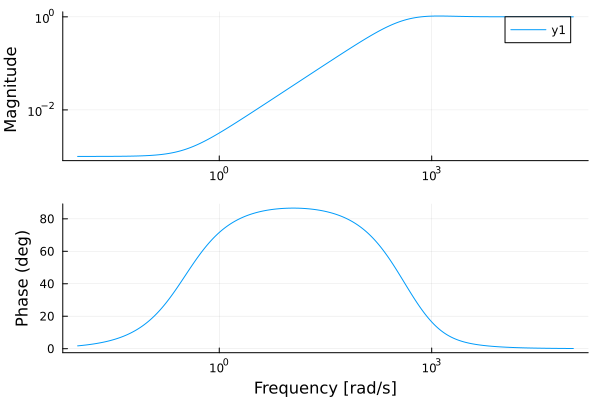

In [466]:
# Desired closed loop bw rad/s
omega_cl = 60*6.6
omega_max = 200*6.6


S_max = 1.2
S_inf = 1.001
S_L = 1e-3


omega_0 = omega_cl/S_max * S_L

omega_r = S_inf/S_max * omega_max

print(omega_0)
print('\n')
print(omega_cl)
print('\n')
print(omega_r)
print('\n')
print(omega_max)


WS = (s/omega_0 + 1)/(s/omega_cl + 1) * (s/omega_max + 1)/(s/omega_r + 1)*S_L 

WS = 1/WS

bodeplot(1/WS)

In [467]:

WT = W_delta

P = hinfpartition(G, WS, WU, WT)
hinfassumptions(P)



All assumtions are satisfied!


true

1.3491043225826764

┌ Warning: Numerical problems encountered, returned γ is adjusted to the γ achieved by the computed controller (γ - γactual = 0.005410499386878875). Try solving the problem in higher precision by calling hinfsynthesize(...; ftype=BigFloat)
└ @ RobustAndOptimalControl C:\Users\elirho\.julia\packages\RobustAndOptimalControl\tw7rk\src\hinfinity_design.jl:203


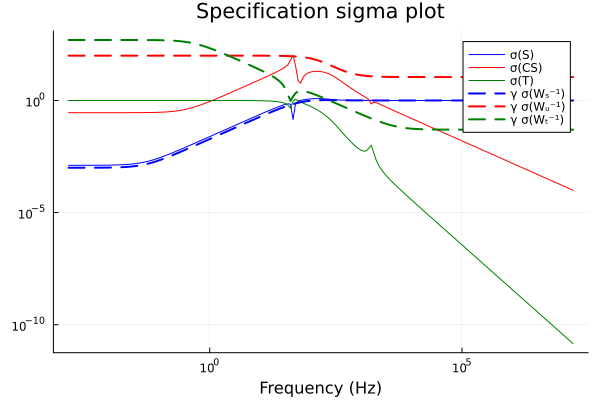

In [468]:
K, y = hinfsynthesize(P, γrel=1.05)
K = minreal(K)
print(y)

Pcl, S, KS, T = hinfsignals(P, G, K)

specificationplot([S,K*S,T], [WS,WU,WT],wint=(-2,8))

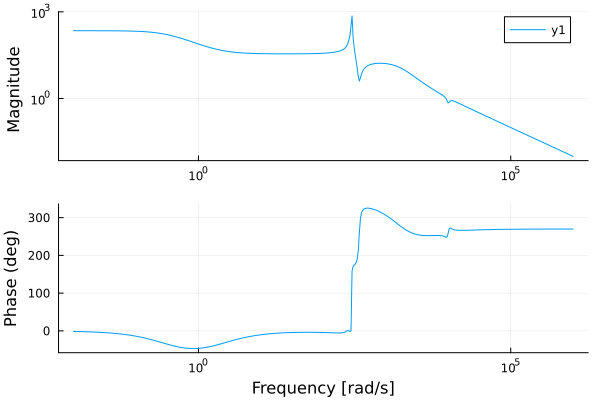

In [469]:
bodeplot(K)

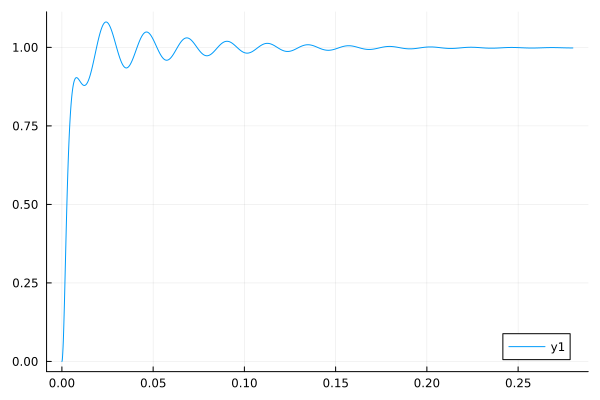

In [470]:
Pcl = G*K/(1 + G*K)

Pcl = minreal(Pcl)
y, t = step(Pcl);
plot(t, y')

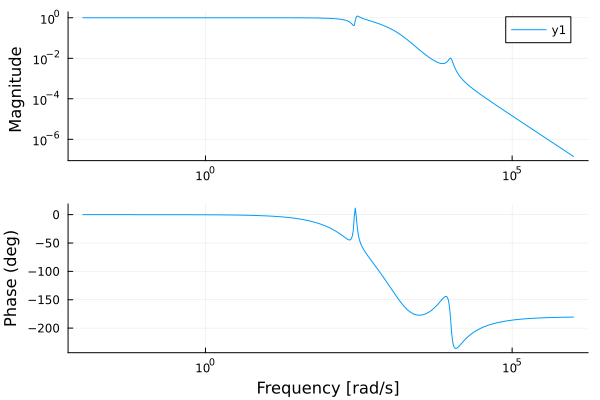

In [471]:



bodeplot(Pcl)

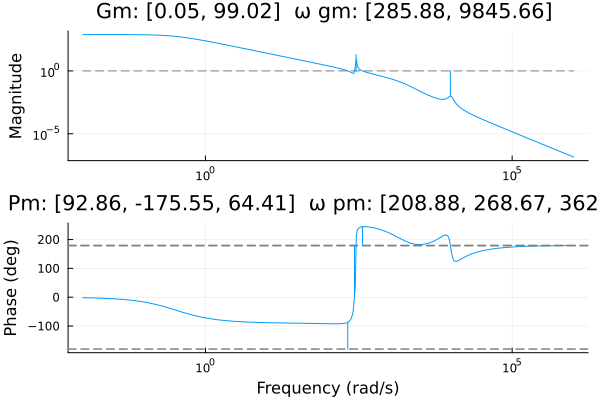

In [472]:
L = minreal(G*K)
marginplot(L)

In [473]:
K = tf(K)

num = K.matrix[1,1].num.coeffs
den = K.matrix[1,1].den.coeffs

fpath = "tf_txt/C_hinf.txt"
open(fpath, "w") do file
    write(file, string(num))
    write(file, "\n")
    write(file, string(den))
end

K

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
       9873.166533499258s^11 + 3.81329848253232e8s^10 + 3.8047448762847085e12s^9 + 4.540142701910074e16s^8 + 2.5543920824083926e20s^7 + 5.87466754547311e23s^6 + 5.055894687887305e26s^5 + 1.46565179148045e29s^4 + 9.082201748217983e31s^3 + 8.189198471454432e33s^2 + 3.627925471493169e36s + 7.574582528039006e36
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^12 + 37326.66282589761s^11 + 3.384858959202241e8s^10 + 4.2873303705370356e12s^9 + 1.953606507591091e16s^8 + 4.287478647322804e19s^7 + 4.955521766631999e22s^6 + 2.7711976344106237e25s^5 + 7.51081772032509e27s^4 + 3.2445547235734945e30s^3 + 2.946913085326133e32s^2 + 1.0348368075729927e35s + 3.411763